In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.initializers import GlorotUniform, HeUniform, HeNormal
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
%pip install tab2img -q # q for quiet
from tab2img.converter import Tab2Img
seed = 314159
np.random.seed(seed)
tf.random.set_seed(seed)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from keras.datasets import cifar10, mnist
from keras.optimizers.legacy import SGD, Adam
from keras.utils import to_categorical
from keras.backend import image_data_format
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Reshape
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import copy
import csv
import random
import time
# Importing necessary libraries for preprocessing and modeling
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Load the dataset
data = pd.read_csv('WSN-DS.csv')
from sklearn.preprocessing import LabelEncoder
print('Shape of Dataframe: ',data.shape,'\n')
print('Inspection of Target Feature - y:\n')
data['Attack type'].value_counts()

Shape of Dataframe:  (374661, 19) 

Inspection of Target Feature - y:



Attack type
Normal       340066
Grayhole      14596
Blackhole     10049
TDMA           6638
Flooding       3312
Name: count, dtype: int64

In [3]:
null_counts = data.isnull().sum()
data.dropna(inplace=True)
duplicate_count = data.duplicated().sum()
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
X = data.copy()
X = data.drop('Attack type', axis=1)
y = data['Attack type']
y = y.astype(str)
y = y.replace({
    'Normal': 0,
    'Grayhole': 1,
    'Blackhole': 2,
    'TDMA': 3,
    'Flooding': 4,
})

y = pd.Series(y)
class_counts = y.value_counts()
class_ratios = class_counts / len(y)

C:\Users\Mo-gh\AppData\Local\Temp\ipykernel_5284\904220694.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({


In [4]:
class_counts = y.value_counts()
print(class_counts)

Attack type
0    332040
1     13909
2     10049
3      6633
4      3157
Name: count, dtype: int64


In [5]:
# Set seed
seed_pi = 314159

# Set numpy seed
np.random.seed(seed_pi)
# Set the seed for TensorFlow
tf.random.set_seed(seed_pi)

In [6]:
def extractAllSets(X,y,p_train,p_val,p_test,random_state=seed_pi,shuffle=True):
    ''''
    Splits a given pandas dataframe X (features) into three subsets:X_train, X_val and X_test.
    Also splits a given pandas series y (target) to y_train, y_val and y_test respectively.
    Fractional ratios are provided by the user, as percentages, namely: p_train, p_valid, p_test.
    These inputs describe the percentage of the extracted sets in reference with the inputs X and y.
    The final sets are extracted by executing method train_test_split() twice.

    Parameters
    ----------
    X: pandas Dataframe
    y: pandas Series
    p_train, p_val, p_test  : float
    random_state : integer
    shuffle: (boolean) Enables shuffling the dataset

    The values should be expressed as float fractions and  should  sum to 1.0.
    The parameter of random_state ensures reproducibility.

    Returns
    -------
    X_train, X_val, X_test :
        Dataframes (features) containing the three splits.
    y_train, y_val, y_test  :
        Series (targets) containig the three splits
    '''
    # The initial train-test split produces X_train and y_train
    # Two additional sets are created X_temp and y_temp, that will produce the rest of the sets
    X_train, X_temp, y_train, y_temp = train_test_split(X,y, stratify=y,
        test_size=(1.0 - p_train), random_state=random_state, shuffle=shuffle)
                                                                        # Enable/desable shuffling
    # Note that by applying the stratify condition we ensure homogeneous distribution
    # of chareacteristics in targets

    # Parameter fraction describes the relevant size of the test size
    fraction = p_test / (p_val + p_test)
    X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,
        test_size=fraction, random_state=random_state, shuffle=shuffle) # Enable/desable shuffling
    # Note that we use the same random_state twice for reproducibility

    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = extractAllSets(X, y, 0.55, 0.1, 0.35)

# Organize all sets in list format
original_data = [X_train, X_val, X_test, y_train, y_val, y_test]

In [8]:
# Initialize QuantileTransformer with uniform distribution
quantile_transformer = QuantileTransformer(n_quantiles=10**3, output_distribution='normal')

# Fit and transform the training data
X_train_transformed = quantile_transformer.fit_transform(X_train)

# Transform the validation and test data using the same transformer
X_val_transformed  = quantile_transformer.transform(X_val)
X_test_transformed = quantile_transformer.transform(X_test)

# Arrange transformed data as a list
scaled_data = [X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test]

In [9]:
Y_train = y_train
Y_test_test = y_test
Y_train = Y_train.to_numpy()
Y_test_test = Y_test_test.to_numpy()


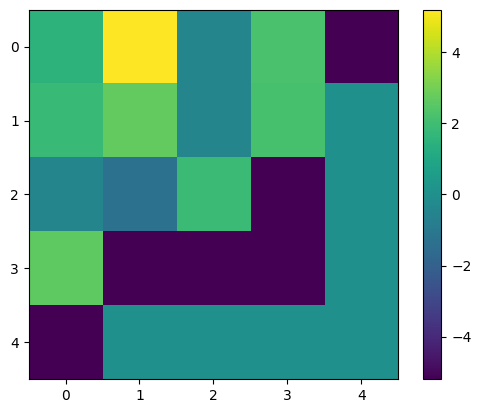

In [10]:
# Define the Tab2Img model
model_tab2img = Tab2Img()

# Convert training data
X_train_images = model_tab2img.fit_transform(X_train_transformed, Y_train)

# Convert validation and test data (using the fitted model)
X_val_images  = model_tab2img.transform(X_val_transformed)
X_test_images = model_tab2img.transform(X_test_transformed)

# Greyscale Transformation - Reshape the image data for CNN input
X_train_images = X_train_images.reshape(-1, 5, 5, 1)
X_val_images   = X_val_images.reshape(-1, 5, 5, 1)
X_test_images  = X_test_images.reshape(-1, 5, 5, 1)

# Visualize an example
plt.imshow(X_train_images[0])
plt.colorbar()
plt.show()

In [11]:
import numpy as np
X_train_images = np.array(X_train_images)
X_val_images = np.array(X_val_images)
X_test_images = np.array(X_test_images)
Y_train = np.array(y_train)
Y_val = np.array(y_val)
Y_test_test = np.array(y_test)

In [12]:
X_train_images.shape, Y_train.shape, X_val_images.shape, Y_val.shape, X_test_images.shape, Y_test_test.shape

((201183, 5, 5, 1),
 (201183,),
 (36578, 5, 5, 1),
 (36578,),
 (128027, 5, 5, 1),
 (128027,))

In [32]:
import random
import numpy as np
import numpy.linalg as lina
from scipy.optimize import linprog
import cvxopt as opt

def subsets_Size_NElem(s, nElems):
    res = []
    for i in range(1 << s):
        bin_string = list(format(i, '0'+str(s)+'b'))
        vec = [float(x) for x in bin_string]
        if (sum(vec) == nElems):
            res.append(vec)
    return res

def multLL(lista, listb):
    return [a*b for a,b in zip(lista,listb)]

def create_lhs_eqCol(nClass, nVars, nDev, vecVars):
    res = []
    for i in range(0, nClass):
        constrCol = [0.0]*nVars
        for j in range(0, nDev):
            pos = i + j*nClass
            constrCol[pos] = 1.0
        restrictedCol = multLL(constrCol, vecVars)
        res.append(restrictedCol)
    return res

def create_lhs_eqCol_weights(nClass, nVars, nDev, vecVars, vecWeights):
    res = []
    for i in range(0, nClass):
        constrCol = [0.0]*nVars
        for j in range(0, nDev):
            pos = i + j*nClass
            constrCol[pos] = vecWeights[j]
        restrictedCol = multLL(constrCol, vecVars)
        res.append(restrictedCol)
    return res

def create_lhs_eqRow(nClass, nVars, nDev, vecVars):
    res = []
    for i in range(0, nDev):
        constrRow = [0.0]*nVars
        for j in range(0, nClass):
            pos = i*nClass + j
            constrRow[pos] = 1.0
        restrictedRow = multLL(constrRow, vecVars)
        res.append(restrictedRow)
    return res

def matrMN(m, n):
    mt = np.zeros((m, n))
    for i in range(0, m):
        mt[i][i] = -1.0
    return mt

def sumColsGetCol(mt):
    return map(sum, mt)

def sumRowsGetRow(mt):
    return sumColsGetCol(np.transpose(mt))

def printMat(mt):
    for i in range(0, len(mt)):
        printRow(mt[i])

def printRow(rw):
    print("[", end='')
    for i in range(0, len(rw)):
        print(rw[i], ' ', end='')
    print("]")

def makeEquationsForZeros(lwZeros):
    return list(map(lambda pos: [0]*(pos) + [1] + [0]*(len(lwZeros)-pos-1), np.where(lwZeros == 0)[0]))

def create_solution_weights(numInstancesClass, classesPerDevice, nCopies, vecWeights=[]):
    totalNRecords = sum(numInstancesClass)
    nClass = len(numInstancesClass)
    oneSetofDevices = subsets_Size_NElem(nClass, classesPerDevice)
    lol = oneSetofDevices * nCopies
    nDev = nCopies * len(oneSetofDevices)
    nVars = nClass * nDev

    sumCols = list(map(lambda x: x*1/totalNRecords, numInstancesClass))

    vecVars = list(np.array(lol).flat)
    if vecWeights == []:
        vecWeights = [1/nDev]*nDev

    lhs_eqCol = create_lhs_eqCol_weights(nClass, nVars, nDev, vecVars, vecWeights)
    rhs_eqCol = sumCols

    lhs_eqRow = create_lhs_eqRow(nClass, nVars, nDev, vecVars)
    rhs_eqRow = [1.0]*nDev

    lhs_probZero = makeEquationsForZeros(np.array(vecVars))
    rhs_probZero = [0]*len(lhs_probZero)
    neq_probZero = len(rhs_probZero)

    lp_lhs_eq = lhs_probZero + lhs_eqCol + lhs_eqRow
    lp_rhs_eq = rhs_probZero + rhs_eqCol + rhs_eqRow
    nConstraints = neq_probZero + nDev + nClass
    rankAllMat = lina.matrix_rank(lp_lhs_eq)
    newRank = lina.matrix_rank(lp_lhs_eq[0:len(lp_lhs_eq)-1])

    if (len(lp_lhs_eq) != rankAllMat) and (newRank == (len(lp_lhs_eq)-1)):
        lp_lhs_eq = lp_lhs_eq[0:len(lp_lhs_eq)-1]
        lp_rhs_eq = lp_rhs_eq[0:len(lp_rhs_eq)-1]
        nConstraints = nConstraints - 1

    mA = opt.matrix(np.array(lp_lhs_eq))
    mb = opt.matrix(lp_rhs_eq, (nConstraints, 1))

    mQ = opt.matrix(np.identity(nVars))
    alphaRandomVector = np.random.uniform(0, 1, nVars)
    mL = opt.matrix(-1*2*alphaRandomVector, (nVars, 1))

    mG = opt.matrix((np.identity(nVars))*-1)
    mh = opt.matrix([0.0]*nVars, (nVars, 1))

    sol = opt.solvers.qp(mQ, mL, G=mG, h=mh, A=mA, b=mb)
    vPDev = multLL(sol['x'], vecVars)
    mtPDev = np.array(vPDev).reshape((nDev, nClass))
    mtPDev = np.clip(mtPDev, 0, None)
    mtNRecDev = list(map(lambda l, e: list(map(lambda el: el*e*totalNRecords, l)), mtPDev, vecWeights))
    return mtNRecDev

def create_assignment(y, mtDevClas2Records):
    nDev = len(mtDevClas2Records)
    record2Dev = [0]*len(y)
    for classPos in range(0, len(set(y))):
        className = list(set(y))[classPos]
        vDev2Records = list(map(lambda x: x[classPos], mtDevClas2Records))
        # Handle the case where no records are assigned to any device for a class
        if sum(vDev2Records) == 0:
            vDev2Probs = [1/nDev] * nDev  # Distribute records evenly across devices
        else:
            vDev2Probs = list(map(lambda x: x/sum(vDev2Records), vDev2Records))
        recordsInClass = np.where(y == className)[0]
        vDevices = np.random.choice(range(1, nDev + 1), size=len(recordsInClass), replace=True, p=vDev2Probs)
        for i in range(0, len(recordsInClass)):
            indexRecord = recordsInClass[i]
            device = vDevices[i]
            record2Dev[indexRecord] = device
    return record2Dev


In [13]:
from keras.layers import Dense, GRU, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.regularizers import l2

input_shape = (5,5,1)
class CustomModel:
    def __init__(self, loss, optimizer, num_classes):
        self.loss = loss
        self.optimizer = optimizer
        self.num_classes = num_classes

    def fl_paper_model(self,train_shape):

          conv_initializer   = HeNormal(seed=seed_pi)
          dense_initializer  = HeUniform(seed=seed_pi)
          output_initializer = GlorotUniform(seed=seed_pi)

          mlp = Sequential([
          Input(shape=(5, 5, 1)),
          Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=conv_initializer),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dense(128, activation = 'selu', kernel_initializer = dense_initializer),
          BatchNormalization(),
          Dropout(0.02),

          Dense(5, activation = 'sigmoid', kernel_initializer = output_initializer)
          ])

          mlp.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
          return mlp
    


# from sklearn.utils.class_weight import compute_class_weight

# def compute_global_class_weights(y_train, num_classes):
#     global_class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=y_train)
#     return dict(enumerate(global_class_weights))

# def filter_class_weights_for_client(global_class_weights, client_labels):
#     # Get the unique labels present in the client's dataset
#     client_unique_labels = np.unique(client_labels)
    
#     # Filter the global class weights to only include the client's labels
#     client_class_weights = {label: global_class_weights[label] for label in client_unique_labels}
    
#     return client_class_weights


In [53]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD

NUMOFCLIENTS = 10 # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5  # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.7
LOCAL_ACC = 1.9
GLOBAL_ACC = 0.7
DROP_RATE = 0
# Model configuration
# LOSS = 'binary_crossentropy'
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 5
lr = 0.0005
# lr = 0.001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = CustomModel(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(X_train_images, Y_train, num_clients):

    # Parameters
    num_clients = 10
    classes_per_device = 2 # Adjust based on your dataset's characteristics
    nCopies = 6

    # Calculate the number of instances per class
    numInstancesClass = list(map(lambda e: np.count_nonzero(y == e), set(Y_train)))

    # Generate the solution weights
    mtDevClas2Records = create_solution_weights(numInstancesClass, classes_per_device, nCopies)

    # Assign the records to clients, ensuring device numbers are within the valid range
    rec2dev = create_assignment(Y_train, mtDevClas2Records)
    rec2dev = [i % num_clients + 1 for i in rec2dev]  # Map device numbers to the range [1, num_clients]

    # Split the data based on device assignments
    client_data = {i: {'X_train_images': [], 'Y_train': []} for i in range(1, num_clients + 1)}
    for idx, device in enumerate(rec2dev):
        # Use .iloc with the index to access rows of X_train
        client_data[device]['X_train_images'].append(X_train_images[idx])
        client_data[device]['Y_train'].append(Y_train[idx])
    # Convert lists to numpy arrays
    for device in client_data:
        client_data[device]['X_train_images'] = np.array(client_data[device]['X_train_images'])
        client_data[device]['Y_train'] = np.array(client_data[device]['Y_train'])

    # client_data now contains the non-i.i.d. distributed data for each client

    for device, data in client_data.items():
        unique, counts = np.unique(data['Y_train'], return_counts=True)
        print(f"Client {device}:")
        print(dict(zip(unique, counts)))


    return client_data

class particle():
    def __init__(self, particle_num, client, x_train, y_train):
        # for check particle id
        self.particle_id = particle_num

        # particle model init
        self.particle_model = client

        # best model init
        self.local_best_model = client
        self.global_best_model = client

        # best score init
        self.local_best_score = 0.0
        self.global_best_score = 0.0

        self.x = x_train
        self.y = y_train

        # acc = acceleration
        self.parm = {'acc':ACC, 'local_acc':LOCAL_ACC, 'global_acc':GLOBAL_ACC}

        # velocities init
        self.velocities = [None] * len(client.get_weights())
        for i, layer in enumerate(client.get_weights()):
            self.velocities[i] = np.random.rand(*layer.shape) / 5 - 0.10

    def train_particle(self):
        print("particle {}/{} fitting".format(self.particle_id+1, NUMOFCLIENTS))

        # set each epoch's weight
        step_model = self.particle_model
        step_weight = step_model.get_weights()

        # new_velocities = [None] * len(step_weight)
        new_weight = [None] * len(step_weight)
        local_rand, global_rand = random.random(), random.random()

        # PSO algorithm applied to weights
        for index, layer in enumerate(step_weight):
            new_v = self.parm['acc'] * self.velocities[index]
            new_v = new_v + self.parm['local_acc'] * local_rand * (self.local_best_model.get_weights()[index] - layer)
            new_v = new_v + self.parm['global_acc'] * global_rand * (self.global_best_model.get_weights()[index] - layer)
            self.velocities[index] = new_v
            new_weight[index] = step_weight[index] + self.velocities[index]

        optimizer = Adam(learning_rate=lr)
        step_model.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])

        step_model.set_weights(new_weight)

        # Recreate the optimizer to avoid the error

        # 4.2 - Early Stopping, Learning Rate Scheduler and Compiling
        # save_model_path = 'checkpoint/checkpoint_particle_{}.weights.h5'.format(self.particle_id)
        save_model_path = 'checkpoint_1/checkpoint_particle_{}.weights.h5'.format(self.particle_id)

        mc = ModelCheckpoint(filepath=save_model_path,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=True)

        early_stopping = EarlyStopping(
            monitor='accuracy',
            patience=10,
            verbose=1,
            restore_best_weights=True)

        reduce_lr = ReduceLROnPlateau(
            monitor='accuracy',
            patience=5,
            min_lr=1e-07,
            verbose=1,
            factor=0.1)

        hist = step_model.fit(x=self.x, y=self.y,
                              epochs=CLIENT_EPOCHS,
                              batch_size=BATCH_SIZE,
                              verbose=1,
                              validation_split=0.1,
                              callbacks=[mc,reduce_lr,early_stopping])

        train_score_loss = hist.history['val_loss'][-1]

        step_model.load_weights(save_model_path)
        self.particle_model = step_model

        if self.global_best_score >= train_score_loss:
            self.local_best_model = step_model

        return self.particle_id, train_score_loss

    def update_global_model(self, global_best_model, global_best_score):
        if self.local_best_score < global_best_score:
            self.global_best_model = global_best_model
            self.global_best_score = global_best_score

    def resp_best_model(self, gid):
        if self.particle_id == gid:
            return self.particle_model


def get_best_score_by_loss(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 100000
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score > result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]


def get_best_score_by_acc(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 0
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score < result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test


    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train, NUMOFCLIENTS)

    server_model = init_model(train_data_shape=train_data_shape)
    # print(server_model.summary())


    pso_model = []
    for i in range(NUMOFCLIENTS):
        # pso_model.append(particle(particle_num=i, client=init_model(train_data_shape = x_train[0].shape[1]), x_train=client_data[i][0], y_train=client_data[i][1]))
        pso_model.append(particle(particle_num=i, client=init_model(train_data_shape = x_train[0].shape[1]), x_train=client_data[i+1]['X_train_images'], y_train=client_data[i+1]['Y_train']))

    server_evaluate_acc = []
    global_best_model = None
    global_best_score = 0.0

    for epoch in range(EPOCHS):
        server_result = []
        start = time.time()

        for client in pso_model:
            if epoch != 0:
                client.update_global_model(server_model, global_best_score)

            pid, train_score = client.train_particle()
            rand = random.randint(0, 99)

            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_result.append([pid, train_score])

        gid, global_best_score = get_best_score_by_loss(server_result)
        for client in pso_model:
            if client.resp_best_model(gid) != None:
                global_best_model = client.resp_best_model(gid)

        server_model = global_best_model

        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedPSO_TORA_WSNDS", server_evaluate_acc)

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

'''Confusion Matrix:
[[116215      0      0      0      0]
 [  4866      0      2      0      0]
 [  3233      0    263     21      0]
 [  2318      0      4      0      0]
 [  1105      0      0      0      0]]'''


Shape of a single data point: (5,)
     pcost       dcost       gap    pres   dres
 0:  1.4742e+01 -1.6770e+01  3e+03  4e+01  3e+00
 1:  2.0196e+01  2.1849e+02  1e+03  2e+01  2e+00
 2:  1.8269e+01  2.2564e+03  2e+03  2e+01  2e+00
 3:  1.8636e+01  4.5559e+04  2e+03  2e+01  2e+00
 4:  1.8767e+01  5.9996e+06  8e+03  2e+01  2e+00
 5:  1.8800e+01  5.5411e+09  1e+05  2e+01  2e+00
 6:  1.8803e+01  1.5691e+13  3e+06  2e+01  2e+00
Terminated (singular KKT matrix).
Client 1:
{0: 45832}
Client 2:
{3: 1344, 4: 624}
Client 3:
{2: 2059, 4: 522}
Client 4:
{2: 1899, 3: 1215}
Client 5:
{1: 2541, 4: 590}
Client 6:
{1: 2626, 3: 1089}
Client 7:
{1: 2483, 2: 1569}
Client 8:
{0: 45665}
Client 9:
{0: 45710}
Client 10:
{0: 45415}
particle 1/10 fitting
Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5786 - loss: 1.4065 - val_accuracy: 1.0000 - val_loss: 0.0930 - learning_rate: 5.0000e-04
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9976 - loss: 0.2316 - val_accuracy: 1.0000

KeyboardInterrupt: 

Shape of a single data point: (5,)
     pcost       dcost       gap    pres   dres
 0:  8.6451e+00 -4.2978e-01  8e+02  3e+01  3e+00
 1:  9.7401e+00  8.2751e+01  5e+02  1e+01  2e+00
 2:  9.3841e+00  1.0593e+03  5e+02  1e+01  2e+00
 3:  9.4246e+00  2.9096e+04  6e+02  1e+01  2e+00
 4:  9.4467e+00  5.5852e+06  3e+03  1e+01  2e+00
 5:  9.4493e+00  1.2350e+10  9e+04  1e+01  2e+00
 6:  9.4494e+00  7.2022e+11  5e+04  1e+01  2e+00
 7:  1.3072e+01  4.7187e+16  2e+16  1e+01  1e+01
 8:  3.1550e+01  1.0290e+17  3e+16  1e+01  8e+00
 9:  3.2440e+01  1.0290e+17  3e+16  1e+01  8e+00
Terminated (singular KKT matrix).
Client 1:
{0: 88691, 3: 385}
Client 2:
{3: 380, 4: 1112}
Client 3:
{2: 1450, 3: 366, 4: 624}
Client 4:
{2: 4077, 3: 345}
Client 5:
{1: 715, 3: 335}
Client 6:
{1: 4520, 3: 414}
Client 7:
{1: 2415, 3: 342}
Client 8:
{0: 34771, 3: 364}
Client 9:
{0: 37552, 3: 340}
Client 10:
{0: 21608, 3: 377}
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
client 1/10 fitting
Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 6

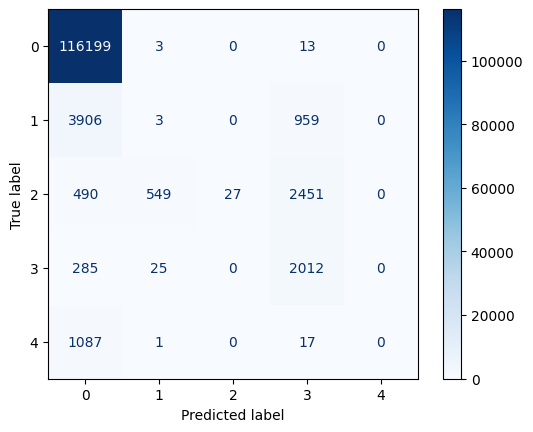

In [20]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD

NUMOFCLIENTS = 10 # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5  # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.3
LOCAL_ACC = 0.7
GLOBAL_ACC = 1.4
DROP_RATE = 0
SELECT_CLIENTS = 1
# Model configuration
# LOSS = 'binary_crossentropy'
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 5
lr = 0.0005
# lr = 0.001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = CustomModel(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(X_train_images, Y_train, num_clients):

    # Parameters
    num_clients = 10
    classes_per_device = 2  # Adjust based on your dataset's characteristics
    nCopies = 2

    # Calculate the number of instances per class
    numInstancesClass = list(map(lambda e: np.count_nonzero(y == e), set(Y_train)))

    # Generate the solution weights
    mtDevClas2Records = create_solution_weights(numInstancesClass, classes_per_device, nCopies)

    # Assign the records to clients, ensuring device numbers are within the valid range
    rec2dev = create_assignment(Y_train, mtDevClas2Records)
    rec2dev = [i % num_clients + 1 for i in rec2dev]  # Map device numbers to the range [1, num_clients]

    # Split the data based on device assignments
    client_data = {i: {'X_train_images': [], 'Y_train': []} for i in range(1, num_clients + 1)}
    for idx, device in enumerate(rec2dev):
        # Use .iloc with the index to access rows of X_train
        client_data[device]['X_train_images'].append(X_train_images[idx])
        client_data[device]['Y_train'].append(Y_train[idx])
    # Convert lists to numpy arrays
    for device in client_data:
        client_data[device]['X_train_images'] = np.array(client_data[device]['X_train_images'])
        client_data[device]['Y_train'] = np.array(client_data[device]['Y_train'])

    # client_data now contains the non-i.i.d. distributed data for each client

    for device, data in client_data.items():
        unique, counts = np.unique(data['Y_train'], return_counts=True)
        print(f"Client {device}:")
        print(dict(zip(unique, counts)))


    return client_data


def fedAVG(server_weight):
    avg_weight = [np.zeros_like(w) for w in server_weight[0]]  # Initialize with the same structure as the first set of weights

    for client_weights in server_weight:
        for i, w in enumerate(client_weights):
            avg_weight[i] += w

    avg_weight = [w / len(server_weight) for w in avg_weight]  # Compute the average

    return avg_weight

def client_update(index, client, now_epoch, avg_weight):
    print("client {}/{} fitting".format(index + 1, int(NUMOFCLIENTS * SELECT_CLIENTS)))

    optimizer = tf.keras.optimizers.Adam()
    client.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    if now_epoch != 0:
        client.set_weights(avg_weight)

    client.fit(client_data[i+1]['X_train_images'],client_data[i+1]['Y_train'],
        epochs=CLIENT_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_split=0.2,
    )

    return client

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test

    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train, NUMOFCLIENTS)
    print(client_data.keys())
    server_model = init_model(train_data_shape=train_data_shape)
    # print(server_model.summary())

    fl_model = []
    for i in range(NUMOFCLIENTS):  # Keys are now starting from 0
        optimizer = Adam(learning_rate=lr)
        fl_model.append(init_model(train_data_shape=train_data_shape,))

    avg_weight = [np.zeros_like(w) for w in server_model.get_weights()]

    server_evaluate_acc = []

    for epoch in range(EPOCHS):
        server_weight = []

        selected_num = int(max(NUMOFCLIENTS * SELECT_CLIENTS, 1))
        split_data_index = []
        while len(split_data_index) < selected_num:
            item = random.choice(range(len(fl_model)))
            if item not in split_data_index:
                split_data_index.append(item)
        split_data_index.sort()
        selected_model = [fl_model[k] for k in split_data_index]

        for index, client in enumerate(selected_model):
            recv_model = client_update(index, client, epoch, avg_weight)

            rand = random.randint(0, 99)
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_weight.append(copy.deepcopy(recv_model.get_weights()))

        avg_weight = fedAVG(server_weight)

        server_model.set_weights(avg_weight)
        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedAvg_TORA_WSNDS", server_evaluate_acc)

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()
'''Confusion Matrix:
[[116199,      3 ,     0,     13 ,     0],
 [  3906,      3 ,     0,    959,      0],
 [   490,    549,     27,   2451 ,     0],
 [   285 ,    25,      0,   2012 ,     0],
 [  1087,      1,      0,     17 ,     0]]'''

Shape of a single data point: (5,)
Client 0:
  Number of samples: 20119
  Class distribution: {0: 18218, 1: 810, 2: 578, 3: 354, 4: 159}

Client 1:
  Number of samples: 20119
  Class distribution: {0: 18263, 1: 781, 2: 566, 3: 338, 4: 171}

Client 2:
  Number of samples: 20119
  Class distribution: {0: 18266, 1: 764, 2: 569, 3: 364, 4: 156}

Client 3:
  Number of samples: 20118
  Class distribution: {0: 18173, 1: 817, 2: 569, 3: 379, 4: 180}

Client 4:
  Number of samples: 20118
  Class distribution: {0: 18336, 1: 755, 2: 522, 3: 325, 4: 180}

Client 5:
  Number of samples: 20118
  Class distribution: {0: 18243, 1: 771, 2: 536, 3: 376, 4: 192}

Client 6:
  Number of samples: 20118
  Class distribution: {0: 18334, 1: 739, 2: 542, 3: 355, 4: 148}

Client 7:
  Number of samples: 20118
  Class distribution: {0: 18204, 1: 712, 2: 603, 3: 408, 4: 191}

Client 8:
  Number of samples: 20118
  Class distribution: {0: 18302, 1: 757, 2: 528, 3: 355, 4: 176}

Client 9:
  Number of samples: 20118
 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 3, 3, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,701 (22.27 KB)

 Trainable params: 5,445 (21.27 KB)

 Non-trainable params: 256 (1.00 KB)

None
client 1/10 fitting
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7315 - loss: 1.2045 - val_accuracy: 0.9406 - val_loss: 0.2245
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9559 - loss: 0.2832 - val_accuracy: 0.9585 - val_loss: 0.1299
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9626 - loss: 0.1292 - val_accuracy: 0.9692 - val_loss: 0.1175
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9700 - loss: 0.0969 - val_accuracy: 0.9712 - val_loss: 0.1020
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9743 - loss: 0.0821 - val_accuracy: 0.9622 - val_loss: 0.1000
client 2/10 fitting
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7325 - loss: 1.2184 - val_accuracy: 0.9252 - val_loss: 0.2595
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9528 - loss: 0.3121 - val_accuracy: 0.9610 - val_loss: 0.1250
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9658 - loss: 0.

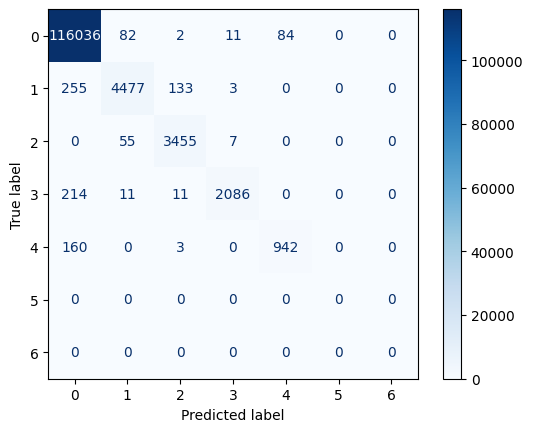

'Confusion Matrix:\n[[68673     0    61     0     2     1     1]\n [   29    22     0     0     0     0     0]\n [  119     0 11143     0     0     0     0]\n [    2     0     0     0     0     0     0]\n [    5     0     4     0    57     0     2]\n [   24     0     1     0     0   295     0]\n [   12     0     0     0     0     0    63]]'

In [14]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD

NUMOFCLIENTS = 10 # number of clients (particles)
EPOCHS = 20  # number of total iterations
CLIENT_EPOCHS = 5  # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.3
LOCAL_ACC = 0.7
GLOBAL_ACC = 1.4
DROP_RATE = 0
SELECT_CLIENTS = 1
# Model configuration
# LOSS = 'binary_crossentropy'
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 7
lr = 0.00001
# lr = 0.0001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = CustomModel(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

import numpy as np

def client_data_config(x_train, y_train):
    num_clients = NUMOFCLIENTS
    num_samples = x_train.shape[0]
    num_per_client = num_samples // num_clients

    # Generate a random permutation of indices
    indices = np.random.permutation(num_samples)

    # Split indices into chunks for each client
    client_indices = np.array_split(indices, num_clients)

    # Prepare client data
    client_data = []
    data_distributions = []

    for i, idxs in enumerate(client_indices):
        new_x_train = x_train[idxs]
        new_y_train = y_train[idxs]

        client_data.append((new_x_train, new_y_train))

        # Record the data distribution for the client
        class_counts = np.bincount(new_y_train)
        class_distribution = {cls: count for cls, count in enumerate(class_counts) if count > 0}

        data_distribution = {
            'client_index': i,
            'num_samples': len(idxs),
            'classes_distribution': class_distribution
        }
        data_distributions.append(data_distribution)

    # Print the data distribution for each client
    for dist in data_distributions:
        print(f"Client {dist['client_index']}:")
        print(f"  Number of samples: {dist['num_samples']}")
        print(f"  Class distribution: {dist['classes_distribution']}")
        print()

    return client_data

def fedAVG(server_weight):
    avg_weight = [np.zeros_like(w) for w in server_weight[0]]  # Initialize with the same structure as the first set of weights

    for client_weights in server_weight:
        for i, w in enumerate(client_weights):
            avg_weight[i] += w

    avg_weight = [w / len(server_weight) for w in avg_weight]  # Compute the average

    return avg_weight

def client_update(index, client, now_epoch, avg_weight):
    print("client {}/{} fitting".format(index + 1, int(NUMOFCLIENTS * SELECT_CLIENTS)))

    optimizer = tf.keras.optimizers.Adam()
    client.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    if now_epoch != 0:
        client.set_weights(avg_weight)

    client.fit(client_data[index][0], client_data[index][1],
        epochs=CLIENT_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_split=0.2,
    )

    return client

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test

    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train)

    server_model = init_model(train_data_shape=train_data_shape)
    print(server_model.summary())

    fl_model = []
    for i in range(NUMOFCLIENTS):  # Keys are now starting from 0
        optimizer = Adam(learning_rate=lr)
        fl_model.append(init_model(train_data_shape=train_data_shape,))

    avg_weight = [np.zeros_like(w) for w in server_model.get_weights()]

    server_evaluate_acc = []

    for epoch in range(EPOCHS):
        server_weight = []

        selected_num = int(max(NUMOFCLIENTS * SELECT_CLIENTS, 1))
        split_data_index = []
        while len(split_data_index) < selected_num:
            item = random.choice(range(len(fl_model)))
            if item not in split_data_index:
                split_data_index.append(item)
        split_data_index.sort()
        selected_model = [fl_model[k] for k in split_data_index]

        for index, client in enumerate(selected_model):
            recv_model = client_update(index, client, epoch, avg_weight)

            rand = random.randint(0, 99)
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_weight.append(copy.deepcopy(recv_model.get_weights()))

        avg_weight = fedAVG(server_weight)

        server_model.set_weights(avg_weight)
        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedAvg_iid_WSNDS", server_evaluate_acc)

# Predict on the test set
# 
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix FedAvg_iid_CICIDS:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

'''Confusion Matrix FedAvg_iid_WSNDS:
[[116036,     82,      2,     11,     84,      ],
 [   255,   4477,    133,      3,      0,      ],
 [     0,     55,   3455,      7,      0,     ],
 [   214,     11,     11,   2086,      0,     ],
 [   160,      0,      3,      0,    942      ]]'''
